Grade=90/100

**ASTRO 361 - Lab 6**

Zack Felker

1 December, 2016

**Introduction:**

We seek to examine the spectral lines of the sun. To do this, we have taken spectrographic data for the sky during the day. We need to calibrate this data, which is the focus of this lab.

**Methods:**

We begin by importing libraries and defining functions. We also define a class. This code is borrowed from analysis I did for a similar physics lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy import ndimage
from numpy import *
from scipy import optimize
from scipy import stats
import pandas as pd
from scipy.optimize import curve_fit

I = 'INTENSITY'
WL = 'WAVELENGTH'
w = 15
class Line:
    
    element = 0
    
    def __init__(self, key):
        self.key = key
        if key >= w and key <= len(foo) - (w-1):
            self.indices = [key + x for x in range (-w, (w-1))]
        
            self.intensities = np.array([foo.ix[key + x, 'INTENSITY'] for x in range (-w, (w-1))])
        
            self.wavelengths =  np.array([foo.ix[key + x, 'WAVELENGTH'] for x in range (-w, (w-1))])
        
            self.center = np.sum(self.wavelengths * (max(self.intensities) - self.intensities) / \
                                np.sum(max(self.intensities) - self.intensities))
            
            self.peakCenter = np.sum(self.wavelengths * ((self.intensities) - min(self.intensities)) / \
                                np.sum((self.intensities) - min(self.intensities)))
            
            self.depth = max(self.intensities) - min(self.intensities)
            
    def isDip(self):
        key = self.key
        if key >= w and key <= len(foo) - (w-1):
            temp = [foo.ix[key + x, 'INTENSITY'] for x in range (-w, (w-1))]
            temp = max(temp) - temp
            temp2 = list(temp)
            temp2[w] = 0
            if temp[w] == max(temp) and (max(temp) != max(temp2) or (temp[w] == temp[w+1] and temp[w-1] != temp[w])):
                return True
            else:
                return False
        else:
            return False
    
    def isPeak(self):
        key = self.key
        if key >= w and key <= len(foo) - (w-1):
            temp = [foo.ix[key + x, 'INTENSITY'] for x in range (-w, (w-1))]
            temp = temp - min(temp)
            temp2 = list(temp)
            temp2[w] = 0
            if temp[w] == max(temp) and (max(temp) != max(temp2) or (temp[w] == temp[w+1] and temp[w-1] != temp[w])) and \
                    (temp[w] < (np.mean(temp2) + 5 * np.std(temp2)) or self.peakCenter > 1400):
                return True
            else:
                return False
        else:
            return False

def getData(name, number):
    out = []
    for i in range (1, number + 1):
        fileName = name + str(i) + '.fit'
        temp = fits.getdata(fileName)
        out.append(temp)
    return out
def rowAvg(imageList, start, number):
    vecList = []
    for image in imageList:
        tempImg = image[start:start + number,0:1530]
        temp = []
        for i in range (0, 1530):
            temp.append(tempImg[0:number,i])
        vecList.append(np.array(temp))
    vecList = np.array(vecList)
    final = []
    for i in range (0,1530):
        final.append(np.median(vecList[0:len(vecList) - 1, i]))
    if len(vecList) == 1:
        final = []
        for i in range (0,1530):
            final.append(np.median(vecList[0, i]))
    return np.array(final)
def calibrate(x, m, b):
    return m * x + b

Next, we read in the data and use the functions above to collapse the images into rows of relative intensity values.

In [2]:
skyList = np.float64(np.array(getData('Sky',5)))
lampList = np.float64(np.array(getData('lamp',1)))
vec = rowAvg(skyList, 250, 151)
lamp = rowAvg(lampList, 250, 151)
indices = []
for i in range (0, 1530):
    indices.append(i)

C:\Users\Zachary\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Now we can take a look at the cropped images to see physically what's happening when we average rows.

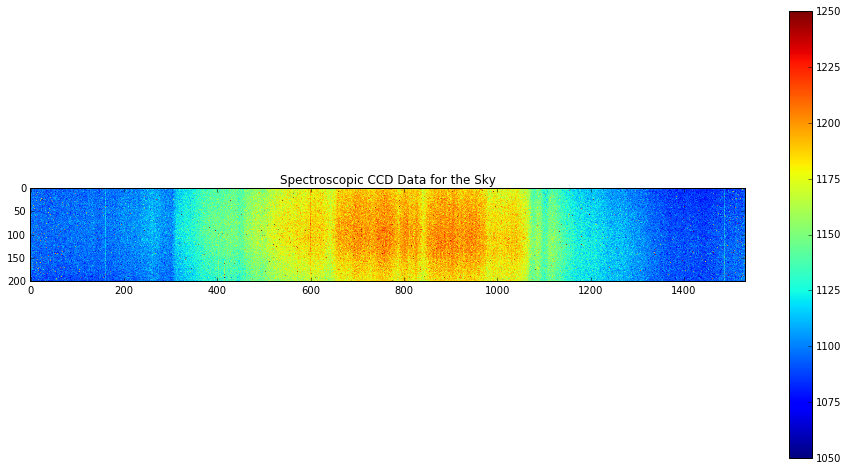

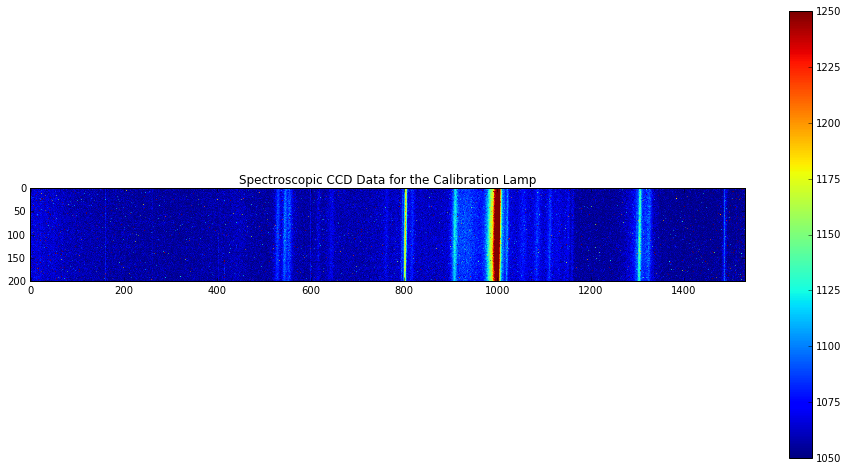

In [3]:
plt.figure(figsize = (16,8))
plt.imshow(skyList[0][200:400,0:1530], vmin = 1050, vmax = 1250)
plt.colorbar()
plt.title('Spectroscopic CCD Data for the Sky')
plt.show()
plt.figure(figsize = (16,8))
plt.imshow(lampList[0][200:400,0:1530], vmin = 1050, vmax = 1250)
plt.colorbar()
plt.title('Spectroscopic CCD Data for the Calibration Lamp')
plt.show()

We then display the calibration data.

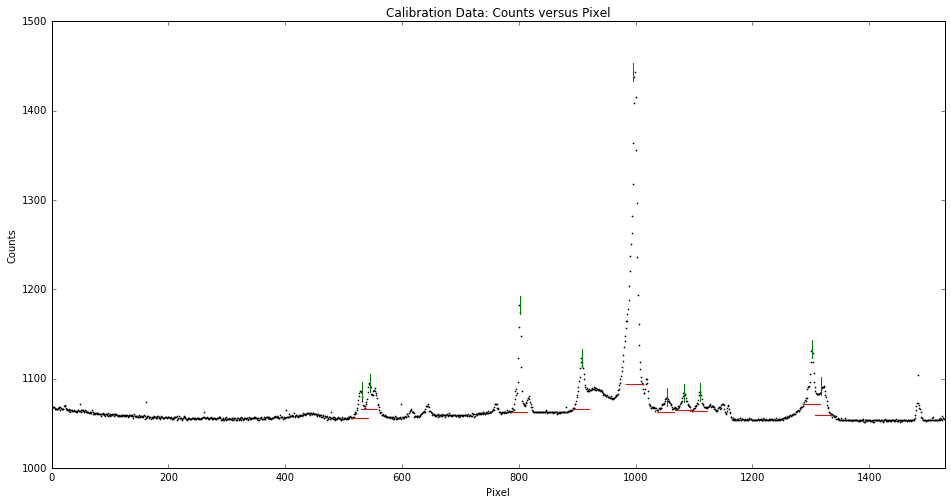

In [4]:
foo = pd.DataFrame()
foo['WAVELENGTH'] = indices
foo['INTENSITY'] = lamp
lines = []
for i in range (0, len(foo)):
    x = Line(i)
    if x.isPeak() and x.depth > 15 and x.key < 1400:
        lines.append(x)
plt.figure(figsize = (16,8))
plt.scatter(foo['WAVELENGTH'], lamp, s = 0.5)
plt.xlim(min(foo['WAVELENGTH']),max(foo['WAVELENGTH']))
for x in lines:
    plt.plot((x.peakCenter, x.peakCenter), (x.intensities[w] + 10, x.intensities[w] - 10), color = 'g')
    plt.plot((min(x.wavelengths), max(x.wavelengths)), (min(x.intensities), min(x.intensities)), color = 'r')
plt.title('Calibration Data: Counts versus Pixel')
plt.xlabel('Pixel')
plt.ylabel('Counts')

We then use the locations of the lines in this data to fit a transformation from pixels to wavelength.

In [5]:
foo = pd.DataFrame()
foo['WAVELENGTH'] = indices
foo['INTENSITY'] = lamp
lines = []
for i in range (0, len(foo)):
    x = Line(i)
    if x.isPeak() and x.depth > 15 and x.key < 1400:
        lines.append(x)

X = [x.peakCenter for x in lines]
Y = [712.6, 709, 610.8, 584, 546, 487.6, 435.8, 404.6, 378, 365]

print curve_fit(calibrate, X, Y)

(array([ -4.62080109e-01,   9.69129918e+02]), array([[  1.26735185e-03,  -1.22267258e+00],
       [ -1.22267258e+00,   1.26534023e+03]]))


We then apply this transformation to the calibration data to ensure it works.

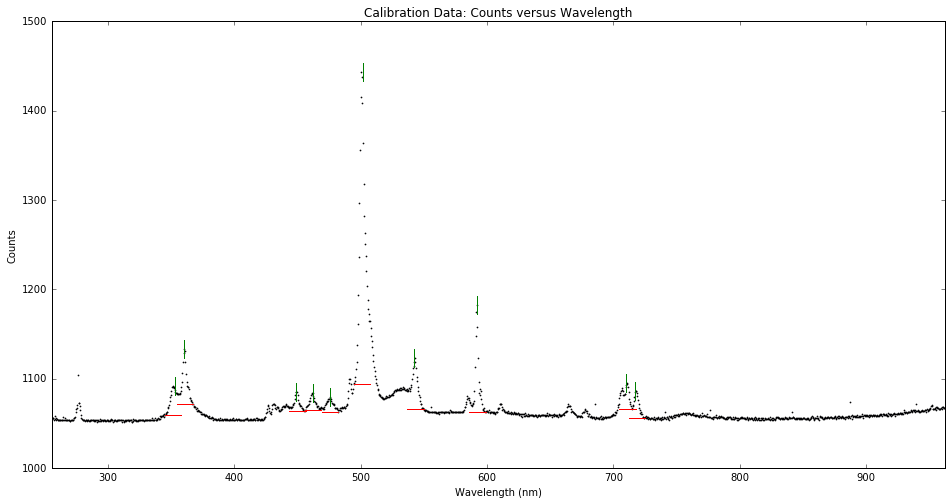

In [6]:
m = -0.4621
b = 962.13
foo = pd.DataFrame()
foo['WAVELENGTH'] = indices
foo['WAVELENGTH'] = [calibrate(x, m, b) for x in foo['WAVELENGTH']]
foo['INTENSITY'] = lamp
lines = []
for i in range (0, len(foo)):
    x = Line(i)
    if x.isPeak() and x.depth > 15 and x.key < 1400:
        lines.append(x)
plt.figure(figsize = (16,8))
plt.scatter(foo['WAVELENGTH'], lamp, s = 0.5)
plt.xlim(min(foo['WAVELENGTH']),max(foo['WAVELENGTH']))
for x in lines:
    plt.plot((x.peakCenter, x.peakCenter), (x.intensities[w] + 10, x.intensities[w] - 10), color = 'g')
    plt.plot((min(x.wavelengths), max(x.wavelengths)), (min(x.intensities), min(x.intensities)), color = 'r')
plt.title('Calibration Data: Counts versus Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')

With this working, we apply the function to the solar data to find the spectral lines.

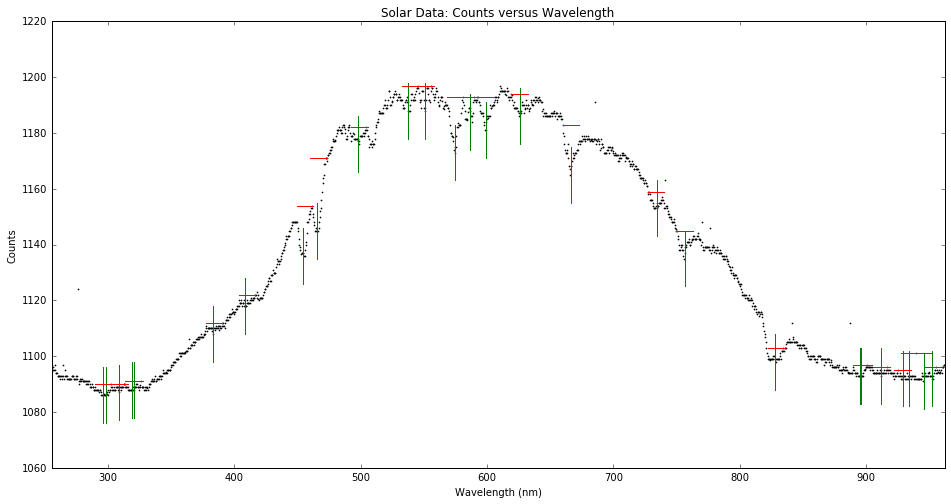

In [7]:
foo = pd.DataFrame()
foo['WAVELENGTH'] = indices
foo['WAVELENGTH'] = [calibrate(x, m, b) for x in foo['WAVELENGTH']]
foo['INTENSITY'] = vec
lines = []
for i in range (0, len(foo)):
    x = Line(i)
    if x.isDip():
        lines.append(x)
plt.figure(figsize = (16,8))
plt.scatter(foo['WAVELENGTH'], vec, s = 0.5)
plt.xlim(min(foo['WAVELENGTH']),max(foo['WAVELENGTH']))
for x in lines:
    plt.plot((x.center, x.center), (x.intensities[w] + 10, x.intensities[w] - 10), color = 'g')
    plt.plot((min(x.wavelengths), max(x.wavelengths)), (max(x.intensities), max(x.intensities)), color = 'r')
plt.title('Solar Data: Counts versus Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')

**Conclusions:**

At what we measure to be 896 nm, we find an oxygen absorbtion line from the atmosphere which has a theoretical wavelength of 899 nm. At 756 nm we find another oxygen line that has theoretical waveltngth 759 nm. Finally, we measure the H-alpha line to occur at 666 nm. The theoretical value for this is 656 nm. The discrepencies here seem to indicate that our calibration is close but not quite right. If we were doing this professionally, more time would be put into ironing out the kinks.